In [1]:
#libraries 
import numpy as np
import pandas as pd
import re
import os


#preprocessing
import string
from time import time  
from nltk.corpus import stopwords #remove stop words
chachedWords = stopwords.words('english')

#translation 
from nltk.translate.bleu_score import sentence_bleu
from gensim import models

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#cosine similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import math
from collections import Counter

#Word Movin Distance
from gensim import models
import gensim.downloader as api
from pyemd import emd

#visualization 
import seaborn as sns

C:\Users\hirom\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Base: https://medium.com/@adriensieg/text-similarities-da019229c894

REF: 
    
https://arxiv.org/pdf/1301.3781.pdf
    
https://www.aclweb.org/anthology/N19-1181.pdf
    
http://proceedings.mlr.press/v37/kusnerb15.pdf

https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/37842.pdf

https://arxiv.org/pdf/1609.08144.pdf

In [2]:
df = pd.read_csv(r"C:\Users\hirom\OneDrive - NOVAIMS\NOVA IMS\OneDrive_1_25-02-2021\Text Mining\Project\corpus\de-en\scores.csv")
df.head(4)

,source,reference,translation,z-score,avg-score,annotators
0,"Ihr Zeitlupentempo maßen sie, als sie vor Spit...",Her timeless pace measures them when they equi...,Their slow speed was measured by researchers o...,-0.345024,76.0,1
1,"Er sagte, dass die Bereiche ruhige Treffpunkte...",He said the areas offer quiet meeting points b...,He said the spaces provided calm meeting point...,0.903800,97.5,2
2,Für die Geschäftsleute an der B 27 ist es nur ...,"For businessmen at the B 27, it's only a small...",This is only a small consolation for businesse...,0.700503,94.0,1
3,Diese Fähigkeit sei möglicherweise angeboren o...,This ability may be born or developed with gen...,"This ability may be innate, or may develop as ...",-1.256572,51.5,2


In [3]:
df.shape

(21704, 6)

In [4]:
df.describe()

,z-score,avg-score,annotators
count,21704.000000,21704.000000,21704.000000
mean,0.000898,71.852890,1.502995
std,0.855140,26.348469,0.810923
min,-5.806322,0.000000,1.000000
25%,-0.499574,56.000000,1.000000
50%,0.216756,79.000000,1.000000
75%,0.640273,94.000000,2.000000
max,2.535434,100.000000,9.000000


In [5]:
pd.pivot_table(df, values = 'annotators', index =['translation'], aggfunc = 'count')

,annotators
translation,
"""A Generation Is Protesting"" in Ethiopia, Long a U.S. Ally",7
"""A Square Meal"" is a feast of historical tidbits.",4
"""A cultural change, a mental change, a physical change,"" Bam said.",4
"""A lot of former customers got priced out of Williamsburg too,"" he said.",5
"""A lot of the stuff I get is late 60s, early 70s, things that came out when I was 11 or 12, things I was probably a bit too young to get,"" he says.",10
...,...
"You're not singing by yourself - and in a group of 50 people singing, who'll hear if a note's out here or there?",9
YouTube Gaming is owned by Google's parent company Alphabet.,9
Young people are particularly vulnerable to this.,5


In [6]:
reference =df['reference']
translation = df['translation']

## Preprocessing 

In [7]:
df.isnull().sum()

source         0
reference      0
translation    0
z-score        0
avg-score      0
annotators     0
dtype: int64

In [8]:
def preprocessing(column):
    pp_column = []
    for sentence in column:
        #exclude punctuation 
        sentence = re.sub(r'[^A-Za-z0-9]',' ',sentence)
        #transform everything in lowercase
        sentence = sentence.lower()
        pp_column.append(sentence)
        
    processed = pd.Series(pp_column)
    return processed

In [9]:
def preprocessing2(sentence):
    return " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in sentence.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in chachedWords)
     

In [10]:
df['p_reference'] = df.apply(lambda x:preprocessing2(x['reference']),axis=1)

In [11]:
df['p_translation'] = df.apply(lambda x:preprocessing2(x['translation']),axis=1)

In [12]:
df_cp = df.copy()

In [13]:
df_cp.head(4)

,source,reference,translation,z-score,avg-score,annotators,p_reference,p_translation
0,"Ihr Zeitlupentempo maßen sie, als sie vor Spit...",Her timeless pace measures them when they equi...,Their slow speed was measured by researchers o...,-0.345024,76.0,1,timeless pace measures equipped six animals br...,slow speed measured researchers svalbard fitt...
1,"Er sagte, dass die Bereiche ruhige Treffpunkte...",He said the areas offer quiet meeting points b...,He said the spaces provided calm meeting point...,0.903800,97.5,2,said areas offer quiet meeting points refugees...,said spaces provided calm meeting points refug...
2,Für die Geschäftsleute an der B 27 ist es nur ...,"For businessmen at the B 27, it's only a small...",This is only a small consolation for businesse...,0.700503,94.0,1,businessmen b it s small consolation custo...,small consolation businesses located along b ...
3,Diese Fähigkeit sei möglicherweise angeboren o...,This ability may be born or developed with gen...,"This ability may be innate, or may develop as ...",-1.256572,51.5,2,ability may born developed gender maturity,ability may innate may develop animal reaches...


In [14]:
def delete_sw(sentence):
    stop_words = stopwords.words('english')
    processed = sentence.split()
    clean = [w for w in processed if w not in chachedWords]
    return clean 

In [15]:
df_cp['w_reference'] = df_cp.apply(lambda x:delete_sw(x['p_reference']),axis=1)

In [16]:
df_cp['w_translation'] = df_cp.apply(lambda x:delete_sw(x['p_translation']),axis=1)

In [17]:
df_cp.head(3)

,source,reference,translation,z-score,avg-score,annotators,p_reference,p_translation,w_reference,w_translation
0,"Ihr Zeitlupentempo maßen sie, als sie vor Spit...",Her timeless pace measures them when they equi...,Their slow speed was measured by researchers o...,-0.345024,76.0,1,timeless pace measures equipped six animals br...,slow speed measured researchers svalbard fitt...,"[timeless, pace, measures, equipped, six, anim...","[slow, speed, measured, researchers, svalbard,..."
1,"Er sagte, dass die Bereiche ruhige Treffpunkte...",He said the areas offer quiet meeting points b...,He said the spaces provided calm meeting point...,0.903800,97.5,2,said areas offer quiet meeting points refugees...,said spaces provided calm meeting points refug...,"[said, areas, offer, quiet, meeting, points, r...","[said, spaces, provided, calm, meeting, points..."
2,Für die Geschäftsleute an der B 27 ist es nur ...,"For businessmen at the B 27, it's only a small...",This is only a small consolation for businesse...,0.700503,94.0,1,businessmen b it s small consolation custo...,small consolation businesses located along b ...,"[businessmen, b, small, consolation, customers...","[small, consolation, businesses, located, alon..."


# 'TESTE

In [18]:
teste = df_cp[df_cp['translation'] == 'Young people are particularly vulnerable to this.']
teste

,source,reference,translation,z-score,avg-score,annotators,p_reference,p_translation,w_reference,w_translation
2842,Junge Leute sind da in besonderer Weise anfällig.,Young people are there in special way suscepti...,Young people are particularly vulnerable to this.,-0.105717,61.0,2,young people special way susceptible,young people particularly vulnerable this,"[young, people, special, way, susceptible]","[young, people, particularly, vulnerable]"
5374,Junge Leute sind da in besonderer Weise anfällig.,Young people are particularly vulnerable.,Young people are particularly vulnerable to this.,1.242500,100.0,1,young people particularly vulnerable,young people particularly vulnerable this,"[young, people, particularly, vulnerable]","[young, people, particularly, vulnerable]"
7253,Junge Leute sind da in besonderer Weise anfällig.,Young people are particularly vulnerable here.,Young people are particularly vulnerable to this.,0.762377,91.0,1,young people particularly vulnerable here,young people particularly vulnerable this,"[young, people, particularly, vulnerable]","[young, people, particularly, vulnerable]"
9352,Junge Leute sind da in besonderer Weise anfällig.,Young people are particularly susceptible to t...,Young people are particularly vulnerable to this.,1.184759,100.0,1,young people particularly susceptible this,young people particularly vulnerable this,"[young, people, particularly, susceptible]","[young, people, particularly, vulnerable]"
18227,Junge Leute sind da in besonderer Weise anfällig.,Young people are in particular vulnerable.,Young people are particularly vulnerable to this.,0.363601,75.0,1,young people particular vulnerable,young people particularly vulnerable this,"[young, people, particular, vulnerable]","[young, people, particularly, vulnerable]"


In [19]:
ref = teste['p_reference'].to_list()

In [20]:
cand = 'young people particularly vulnerable this'

## Embedding

https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/

Doc2Vec

In [21]:
# import
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(df_cp['w_translation'])]
tagged_data

[TaggedDocument(words=['slow', 'speed', 'measured', 'researchers', 'svalbard', 'fitted', 'six', 'animals', 'tracker'], tags=[0]),
 TaggedDocument(words=['said', 'spaces', 'provided', 'calm', 'meeting', 'points', 'refugees', 'volunteers'], tags=[1]),
 TaggedDocument(words=['small', 'consolation', 'businesses', 'located', 'along', 'b', 'road', 'reopened', 'customers', 'rottenburg'], tags=[2]),
 TaggedDocument(words=['ability', 'may', 'innate', 'may', 'develop', 'animal', 'reaches', 'sexual', 'maturity'], tags=[3]),
 TaggedDocument(words=['generally', 'come', 'surface', 'winter', 'prefer', 'water', 'temperatures', 'around', 'six', 'degrees', 'celsius'], tags=[4]),
 TaggedDocument(words=['bn', 'project', 'due', 'complete', 'may'], tags=[5]),
 TaggedDocument(words=['time', 'look', 'needs', 'community', 'legal', 'centres', 'client', 'communities', 'palaszczuk', 'government', 'invest', 'important', 'work'], tags=[6]),
 TaggedDocument(words=['appreciate', 'work', 'put', 'team', 'devon', 'cornw

In [22]:
## Train doc2vec model
model_Doc2Vec = Doc2Vec(tagged_data, vector_size = 5, window = 2, min_count = 1, epochs = 100)



In [23]:
model_Doc2Vec.wv.index_to_key

['said',
 'people',
 'year',
 'one',
 'time',
 'new',
 'years',
 'also',
 'would',
 'first',
 'old',
 'mr',
 'two',
 'police',
 'like',
 'around',
 'percent',
 'even',
 'last',
 'world',
 'according',
 'could',
 'many',
 'three',
 'olympic',
 'says',
 'trump',
 'state',
 'women',
 'back',
 'day',
 'team',
 'long',
 'company',
 'thursday',
 'made',
 'friday',
 'already',
 'put',
 'group',
 'germany',
 'euros',
 'since',
 'president',
 'take',
 'work',
 'months',
 'get',
 'men',
 'make',
 'million',
 'clinton',
 'water',
 'association',
 'good',
 'games',
 'final',
 'another',
 'country',
 'however',
 'security',
 'still',
 'way',
 'left',
 'go',
 'able',
 'right',
 'going',
 'saying',
 'much',
 'place',
 'rio',
 'told',
 'customers',
 'used',
 'well',
 'house',
 'things',
 'say',
 'doping',
 'second',
 'four',
 'come',
 'start',
 'bank',
 'several',
 'record',
 'found',
 'end',
 'young',
 'result',
 'line',
 'see',
 'set',
 'government',
 'german',
 'us',
 'ago',
 'north',
 'attacks',
 

In [24]:
x = model_Doc2Vec.infer_vector(df_cp['w_reference'][4])

In [25]:
model_Doc2Vec.docvecs.most_similar([x])

[(4699, 0.9857627153396606),
 (12617, 0.9857029914855957),
 (8237, 0.9835290312767029),
 (11225, 0.982798159122467),
 (10946, 0.9826377630233765),
 (16039, 0.9804432988166809),
 (4259, 0.9791126847267151),
 (20632, 0.9791022539138794),
 (12188, 0.9780997633934021),
 (13017, 0.9761375784873962)]

In [26]:
t = model_Doc2Vec.infer_vector(df_cp['w_translation'][4])

In [27]:
r = model_Doc2Vec.infer_vector(df_cp['w_reference'][4])

In [28]:
t

array([ 0.43651682, -0.5343189 ,  1.0501677 , -2.0009184 , -0.9346805 ],
      dtype=float32)

In [29]:
r

array([ 0.35736012, -0.64000505,  0.11377381, -1.5491319 , -0.1840936 ],
      dtype=float32)

## Similarity 

## Doc2Vec + Cosine Similarity 

In [30]:
from scipy import spatial
def cosinesimilarity(ref,trans):
    t = model_Doc2Vec.infer_vector(trans)
    r = model_Doc2Vec.infer_vector(ref)
    result = 1 - spatial.distance.cosine(t,r)
    return result

REF: https://www.machinelearningplus.com/nlp/cosine-similarity/

The cosine similarity is advantageous because even if the two similar documents are far apart by the Euclidean distance (due to the size of the document), chances are they may still be oriented closer together. The smaller the angle, higher the cosine similarity.

In [31]:
cosinesimilarity(df_cp['w_reference'][4],df_cp['w_translation'][4])

0.862173855304718

**Interpretation** : A cosine value of 0 means that the two vectors are at 90 degrees to each other (orthogonal) and have no match. The closer the cosine value to 1, the smaller the angle and the greater the match between vectors. 

## W2V(google) + Word Mover Distance

REF: https://towardsdatascience.com/word-movers-distance-for-text-similarity-7492aeca71b0


In [32]:
cand_f = 'olympics  brazen cheating in doping tests'.split()

In [33]:
#libraries 
from time import time 
#remove stop words 
from nltk.corpus import stopwords
import os
from gensim import models
import gensim.downloader as api
from pyemd import emd

In [34]:
#tokenized data 
def delete_sw(lista):
    stop_words = stopwords.words('english')
    finalresult = []
    for sentence in lista:
        processed = sentence.split()
        clean = []
        for word in processed:
            if word not in stop_words:
                clean.append(word)
        finalresult.append(clean)
    return finalresult 

In [35]:
modelGOOGLEWMD = api.load('word2vec-google-news-300')


https://towardsdatascience.com/word-distance-between-word-embeddings-cc3e9cf1d632
https://radimrehurek.com/gensim/auto_examples/tutorials/run_wmd.html
    
The sentence can have no similar words, but by the relevand words in each sentence, it's possible to identify the "semantical distance" between them. 
With this method we can evaluate how the reference of translation is close to the real translation.

## BLEU 

In [37]:
df_cp

,source,reference,translation,z-score,avg-score,annotators,p_reference,p_translation,w_reference,w_translation
0,"Ihr Zeitlupentempo maßen sie, als sie vor Spit...",Her timeless pace measures them when they equi...,Their slow speed was measured by researchers o...,-0.345024,76.0,1,timeless pace measures equipped six animals br...,slow speed measured researchers svalbard fitt...,"[timeless, pace, measures, equipped, six, anim...","[slow, speed, measured, researchers, svalbard,..."
1,"Er sagte, dass die Bereiche ruhige Treffpunkte...",He said the areas offer quiet meeting points b...,He said the spaces provided calm meeting point...,0.903800,97.5,2,said areas offer quiet meeting points refugees...,said spaces provided calm meeting points refug...,"[said, areas, offer, quiet, meeting, points, r...","[said, spaces, provided, calm, meeting, points..."
2,Für die Geschäftsleute an der B 27 ist es nur ...,"For businessmen at the B 27, it's only a small...",This is only a small consolation for businesse...,0.700503,94.0,1,businessmen b it s small consolation custo...,small consolation businesses located along b ...,"[businessmen, b, small, consolation, customers...","[small, consolation, businesses, located, alon..."
3,Diese Fähigkeit sei möglicherweise angeboren o...,This ability may be born or developed with gen...,"This ability may be innate, or may develop as ...",-1.256572,51.5,2,ability may born developed gender maturity,ability may innate may develop animal reaches...,"[ability, may, born, developed, gender, maturity]","[ability, may, innate, may, develop, animal, r..."
4,Weil sie Wassertemperaturen um die sechs Grad ...,Because they prefer water temperatures around ...,They generally only come to the surface in win...,0.293909,87.0,2,prefer water temperatures around six degrees c...,generally come surface winter prefer water tem...,"[prefer, water, temperatures, around, six, deg...","[generally, come, surface, winter, prefer, wat..."
...,...,...,...,...,...,...,...,...,...,...
21699,"Lt. Cmdr. Patrick Evans, ein Pressesprecher de...","Lt. Cmdr. Patrick Evans, a press officer at th...","Lt. Cmdr. Patrick Evans, a Pentagon spokesman,...",1.246459,100.0,1,lt cmdr patrick evans press officer pentago...,lt cmdr patrick evans pentagon spokesman s...,"[lt, cmdr, patrick, evans, press, officer, pen...","[lt, cmdr, patrick, evans, pentagon, spokesman..."
21700,"""Um ein Beispiel zu geben: Wenn ich ihn etwas ...","""To give an example: If I ask him something th...","""To give an example: If I ask him what happene...",0.792878,98.0,1,to give example ask something two years back...,to give example ask happened two years ago s...,"[give, example, ask, something, two, years, ba...","[give, example, ask, happened, two, years, ago..."
21701,"Ein Grund dafür, dass nicht alle Nachbarn das ...",One reason that not all neighbours view this a...,One reason for not all neighbours seeing this ...,0.597068,76.0,1,one reason neighbours view problem may necessa...,one reason neighbours seeing problem could dir...,"[one, reason, neighbours, view, problem, may, ...","[one, reason, neighbours, seeing, problem, cou..."
21702,Der Gewinn vor Zinsen und Steuern erhöhte sich...,Profit before interest and tax increased from ...,Profits before interest and taxes increased fr...,-0.305719,61.0,1,profit interest tax increased million ...,profits interest taxes increased million ...,"[profit, interest, tax, increased, million, mi...","[profits, interest, taxes, increased, million,..."


In [38]:
from nltk.translate.bleu_score import sentence_bleu

In [39]:
df_cp.iloc[800,:]

source           CHIO: "Goldene Sportpyramide" für Bernhard Langer
reference          CHIO: golden Sports Pyramid for Bernhard Langer
translation       CHIO: "Golden Sport Pyramid" for Bernhard Langer
z-score                                                   0.903944
avg-score                                                     98.5
annotators                                                       2
p_reference            chio  golden sports pyramid bernhard langer
p_translation         chio   golden sport pyramid  bernhard langer
w_reference      [chio, golden, sports, pyramid, bernhard, langer]
w_translation     [chio, golden, sport, pyramid, bernhard, langer]
Name: 800, dtype: object

In [40]:
score_bleu = sentence_bleu([df_cp['w_reference'][800]], df_cp['w_translation'][800])
score_bleu

7.262123179505913e-78

## ADD the embedding comparation in the table 

In [41]:
df_cp['D2V_CosSim'] = df_cp.apply(lambda x:cosinesimilarity(x['w_reference'],x['w_translation']), axis=1)

In [42]:
df_cp['D2V_WMD'] = df_cp.apply(lambda x:model_Doc2Vec.wv.wmdistance(x['w_reference'],x['w_translation']), axis=1)

In [43]:
df_cp['W2VGoogle_WMD'] = df_cp.apply(lambda x:modelGOOGLEWMD.wmdistance(x['w_reference'],x['w_translation']), axis=1)

In [44]:
df_cp['BLEU'] = df_cp.apply(lambda x:sentence_bleu([x['w_reference']],x['w_translation']), axis=1)

In [45]:
df_cp.describe()

,z-score,avg-score,annotators,D2V_CosSim,D2V_WMD,W2VGoogle_WMD,BLEU
count,21704.000000,21704.000000,21704.000000,21704.000000,2.170400e+04,2.170400e+04,2.170400e+04
mean,0.000898,71.852890,1.502995,0.687321,inf,inf,1.321164e-01
std,0.855140,26.348469,0.810923,0.300636,NaN,NaN,2.196728e-01
min,-5.806322,0.000000,1.000000,-0.948079,0.000000e+00,0.000000e+00,0.000000e+00
25%,-0.499574,56.000000,1.000000,0.567055,2.573616e-01,3.566816e-01,6.836366e-155
50%,0.216756,79.000000,1.000000,0.785533,3.604014e-01,5.076215e-01,3.603235e-78
75%,0.640273,94.000000,2.000000,0.903995,4.834998e-01,6.671028e-01,2.624078e-01
max,2.535434,100.000000,9.000000,0.999752,inf,inf,1.000000e+00


In [46]:
df_cp2 = df_cp.copy()

In [47]:
len(df_cp2[df_cp2['D2V_WMD']==np.inf])/len(df_cp2)

0.002165499447106524

In [48]:
df_filter = df_cp2[df_cp2['D2V_WMD']!=np.inf]

In [49]:
df_filter.sort_values(by='BLEU', ascending = False)

,source,reference,translation,z-score,avg-score,annotators,p_reference,p_translation,w_reference,w_translation,D2V_CosSim,D2V_WMD,W2VGoogle_WMD,BLEU
7317,"Ich würde sagen, dass wir Bernsteins Musik wir...",I would say we really have Bernstein's music i...,I would say that we really have Bernstein's mu...,-0.705823,85.50,2,would say really bernstein s music blood,would say really bernstein s music blood,"[would, say, really, bernstein, music, blood]","[would, say, really, bernstein, music, blood]",0.996705,0.000000,0.000000,1.0
19864,Medienberichten zufolge soll er bei seiner Rüc...,"According to media reports, he should have bee...","According to media reports, he was arrested on...",-0.950026,63.00,1,according media reports arrested return nairo...,according media reports arrested return nairo...,"[according, media, reports, arrested, return, ...","[according, media, reports, arrested, return, ...",0.990227,0.000000,0.000000,1.0
5783,"""Ich habe Wasser an Orten gesehen, an denen ic...","""I've seen water in places I've never seen bef...","""I've seen water in some places I have never s...",0.660102,100.00,1,i ve seen water places i ve never seen before...,i ve seen water places never seen before to...,"[seen, water, places, never, seen, townson, sa...","[seen, water, places, never, seen, townson, sa...",0.991952,0.000000,0.000000,1.0
11963,Aber es ist keine typische Zeichensprache -- s...,But it is not a typical sign language -- it sa...,But it's not just typical sign language -- she...,-0.354548,52.00,1,typical sign language says edmund invented...,it s typical sign language says edmund inve...,"[typical, sign, language, says, edmund, invent...","[typical, sign, language, says, edmund, invent...",0.989551,0.000000,0.000000,1.0
5740,"""Singen bewegt mich - emotional und körperlich...","""Singing moves me - emotionally and physically...","""Singing moves me - emotionally and physically...",1.241415,100.00,1,singing moves emotionally physically desc...,singing moves emotionally physically desc...,"[singing, moves, emotionally, physically, desc...","[singing, moves, emotionally, physically, desc...",0.988334,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8280,Die fallen dafür nun aber umso umfangreicher aus.,But these are all the more extensive.,"However, they are more comprehensive as a result.",0.465052,94.50,2,extensive,however comprehensive result,[extensive],"[however, comprehensive, result]",0.352914,1.585712,1.225471,0.0
10739,Das ist wirklich sehr beschämend.,That is really very shameful.,It is in itself a great shame.,-0.432157,74.75,4,really shameful,great shame,"[really, shameful]","[great, shame]",0.322237,0.958964,0.914778,0.0
6140,"Es war dicker und größer, es lag deshalb auch ...","It was thick and bigger, so it was not good en...","It was thicker and larger, and harder to hold.",-1.586257,12.00,1,thick bigger good enough,thicker larger harder hold,"[thick, bigger, good, enough]","[thicker, larger, harder, hold]",0.772180,0.860437,0.995060,0.0
13460,"""Es handelt sich um einen Tötungsdelikt.""","""It's a kill-up.""","""It is a homicide.""",-1.939518,8.00,1,it s kill up,it homicide,[kill],[homicide],0.518433,1.157528,1.275968,0.0


## Preprocessing Predictive model 

In [50]:
df_predict = df_filter[['z-score','avg-score','D2V_CosSim','D2V_WMD','W2VGoogle_WMD','BLEU']]

<AxesSubplot:>

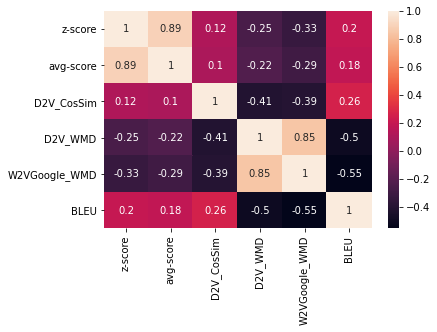

In [51]:
sns.heatmap(df_predict.corr(), annot = True)

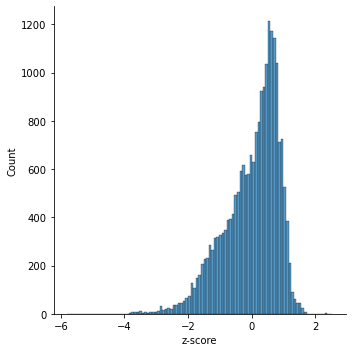

In [52]:
sns.displot(df_predict, x='z-score')

In [53]:
df_predict[df_predict['z-score']>0].describe()

,z-score,avg-score,D2V_CosSim,D2V_WMD,W2VGoogle_WMD,BLEU
count,12671.000000,12671.000000,12671.000000,12671.000000,12671.000000,1.267100e+04
mean,0.587915,88.946305,0.713731,0.350549,0.464023,1.636080e-01
std,0.324137,10.256151,0.288049,0.189534,0.224630,2.430007e-01
min,0.000564,43.000000,-0.884966,0.000000,0.000000,0.000000e+00
25%,0.338521,82.000000,0.604200,0.231245,0.310433,7.711524e-155
50%,0.581665,92.000000,0.810525,0.328541,0.454908,4.493016e-78
75%,0.810439,98.000000,0.918419,0.443389,0.607858,3.253289e-01
max,2.535434,100.000000,0.999752,1.827973,1.375857,1.000000e+00


In [54]:
colunas = df_predict.columns

In [55]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

In [56]:
df_ncp = pd.DataFrame(scale.fit_transform(df_predict))

In [57]:
df_ncp.columns = colunas

In [58]:
df_ncp

,z-score,avg-score,D2V_CosSim,D2V_WMD,W2VGoogle_WMD,BLEU
0,-0.406514,0.156367,-0.545235,1.466673,1.570060,-0.602326
1,1.056184,0.973107,-0.211050,-0.388109,-0.595015,1.060652
2,0.818070,0.840150,0.551816,0.663917,0.559842,-0.602326
3,-1.474174,-0.774336,0.762630,0.742430,0.836956,-0.602326
4,0.341843,0.574234,0.587381,-1.106433,-1.326610,2.270735
...,...,...,...,...,...,...
21652,1.457526,1.068077,0.659470,-0.478598,-0.522299,1.072848
21653,0.926265,0.992101,0.495066,-0.804653,-0.606815,-0.602326
21654,0.696921,0.156367,0.438025,-0.713738,-0.330381,-0.602326
21655,-0.360478,-0.413451,0.740955,-0.376862,-0.328204,-0.602326
